In [1]:
import numpy as np
import sklearn
import tensorflow as tf
import pandas as pd

In [2]:
TRAINING_DATA_PATH = "./data/train.csv"
TESTING_DATA_PATH = "./data/test.csv"

In [3]:
train_df = pd.read_csv(TRAINING_DATA_PATH)
train_df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [4]:
test_df = pd.read_csv(TESTING_DATA_PATH)
test_df.head()

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


In [5]:
#COncatnate both dataframe and shuffle
df = pd.concat([train_df,train_df])
df.tail(5)

,id,title,author,text,label
20795,20795,Rapper T.I.: Trump a ’Poster Child For White S...,Jerome Hudson,Rapper T. I. unloaded on black celebrities who...,0
20796,20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",Benjamin Hoffman,When the Green Bay Packers lost to the Washing...,0
20797,20797,Macy’s Is Said to Receive Takeover Approach by...,Michael J. de la Merced and Rachel Abrams,The Macy’s of today grew from the union of sev...,0
20798,20798,"NATO, Russia To Hold Parallel Exercises In Bal...",Alex Ansary,"NATO, Russia To Hold Parallel Exercises In Bal...",1
20799,20799,What Keeps the F-35 Alive,David Swanson,"David Swanson is an author, activist, journa...",1


In [6]:
from sklearn.utils import shuffle
df = shuffle(df)
df.head()

,id,title,author,text,label
3984,3984,Fifteen Quotes Proving False Flag Terrorism & ...,stevew,"ARJUN WALIA OCTOBER 18, 2016 Tensions between ...",1
18176,18176,"Rigged Primary, Media, and Candidate; the Amer...",NaN,Email \n\nThe excitement over the US election ...,1
9739,9739,Trump: Hillary Clintons policy for Syria would...,Profusion,link She and Nutinbutayahoo have been wanting ...,1
10150,10150,"Three Texas Border City Cops Shot, 1 Injured, ...",Bob Price,"An armed murder suspect allegedly opened fire,...",0
1423,1423,NaN,curriec,"In other words, in his first 100 days, Donald ...",1


In [7]:
#Take away id
df = df.drop('id',axis = 1)
df.shape


(41600, 4)

In [8]:
df.title=df.title.astype(str)
df.text=df.text.astype(str)
df.author=df.author.astype(str)

* Labels are already in encoded format where 1 means real and 0 means fake

* We then extract the labels from the dataframae as a numpy array


In [9]:
label = df['label'].values
print(label.shape)

(41600,)


- The rest are our x values for training
- Let us extract them by droping the label column

In [10]:
data = df.drop('label',axis = 1)
print(data.shape)

(41600, 3)


- Machine learning models prefere to be trained on numbers than strings.
- To make it our news understandable, we will use the "bag of words" concept, where we extract about 400 common features from the data set.
- We use the keras tokinizer to transform the words to it binary matrices.

In [11]:
class TextProcessor(object):
    def __init__(self,vocab_size):
        self._vocab_size = vocab_size
        self._tokenizer = None
    def create_tokenizer(self,text_list):
        tokenizer =  tf.keras.preprocessing.text.Tokenizer(num_words = self._vocab_size)
        tokenizer.fit_on_texts(text_list)
        self._tokenizer = tokenizer
        
    def transform_text(self,text_list):
        tokinizer_matrix = self._tokenizer.texts_to_matrix(text_list)
        return tokinizer_matrix

- It is neccessary to use a class so that u can save the object of it. Will be neccessay during model deployment

- Now we create on object of our class and tranform text

In [12]:
pocessor = TextProcessor(400)

- We will combile all the words in the different columns together so that we can encode them together

In [13]:
all_sentences = list()
for column in data.values:
    for news in column:
        all_sentences.append(news)
len(data['author'].values)

41600

- Now we go ahead and tranform our data into encoded bag of words
- We will initialize the tokinizer with all the sentences we just created so that it will index all the words.
- After that we will encode each feature seprately

In [14]:
pocessor.create_tokenizer(all_sentences)
# title = np.array(pocessor.transform_text(data['title'].values))
# body = np.array(pocessor.transform_text(data['text'].values))
# author = np.array(pocessor.transform_text(data['author'].values))
data2= [pocessor.transform_text(column) for column in data.values]

In [15]:

# data2 =  np.concatenate((title,body,author),axis=1)

In [16]:
data2 = np.array(data2)  
data2.shape

(41600, 3, 400)

In [17]:
import pickle
with open('./processor_state.pkl','wb') as f:
    pickle.dump(pocessor,f)

In [18]:
train_size = int(len(df)*.8)
train_labels = label[:train_size]
test_labels = label[train_size:]
data_train = data2[:train_size]
data_test = data2[train_size:]

In [19]:
data_test.shape

(8320, 3, 400)

In [20]:
from keras.models import Sequential
from keras.layers import Flatten, Dense
model = Sequential()
model.add(Dense(128,input_shape = (3,400) ,activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='softmax'))
model.compile(optimizer='adam',loss="binary_crossentropy", metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 3, 128)            51328     
_________________________________________________________________
dense_1 (Dense)              (None, 3, 64)             8256      
_________________________________________________________________
dense_2 (Dense)              (None, 3, 1)              65        
Total params: 59,649
Trainable params: 59,649
Non-trainable params: 0
_________________________________________________________________


In [21]:
history = model.fit(data_train, train_labels,
epochs=100,
batch_size=128,
validation_split=0.2)

Epoch 1/100
208/208 [==============================] - 1s 4ms/step - loss: 7.6138 - accuracy: 0.5007 - val_loss: 7.7369 - val_accuracy: 0.4926
Epoch 2/100
208/208 [==============================] - 0s 2ms/step - loss: 7.7029 - accuracy: 0.4949 - val_loss: 7.7369 - val_accuracy: 0.4926
Epoch 3/100
208/208 [==============================] - 1s 3ms/step - loss: 7.6050 - accuracy: 0.5013 - val_loss: 7.7369 - val_accuracy: 0.4926
Epoch 4/100
208/208 [==============================] - 1s 4ms/step - loss: 7.5696 - accuracy: 0.5036 - val_loss: 7.7369 - val_accuracy: 0.4926
Epoch 5/100
208/208 [==============================] - 1s 3ms/step - loss: 7.6527 - accuracy: 0.4982 - val_loss: 7.7369 - val_accuracy: 0.4926
Epoch 6/100
208/208 [==============================] - 1s 3ms/step - loss: 7.5835 - accuracy: 0.5027 - val_loss: 7.7369 - val_accuracy: 0.4926
Epoch 7/100
208/208 [==============================] - 1s 3ms/step - loss: 7.6199 - accuracy: 0.5003 - val_loss: 7.7369 - val_accuracy: 0.4926

Epoch 58/100
208/208 [==============================] - 1s 2ms/step - loss: 7.6427 - accuracy: 0.4988 - val_loss: 7.7369 - val_accuracy: 0.4926
Epoch 59/100
208/208 [==============================] - 1s 2ms/step - loss: 7.6752 - accuracy: 0.4967 - val_loss: 7.7369 - val_accuracy: 0.4926
Epoch 60/100
208/208 [==============================] - 1s 2ms/step - loss: 7.6286 - accuracy: 0.4997 - val_loss: 7.7369 - val_accuracy: 0.4926
Epoch 61/100
208/208 [==============================] - 0s 2ms/step - loss: 7.5342 - accuracy: 0.5059 - val_loss: 7.7369 - val_accuracy: 0.4926
Epoch 62/100
208/208 [==============================] - 1s 2ms/step - loss: 7.6231 - accuracy: 0.5001 - val_loss: 7.7369 - val_accuracy: 0.4926
Epoch 63/100
208/208 [==============================] - 1s 3ms/step - loss: 7.6276 - accuracy: 0.4998 - val_loss: 7.7369 - val_accuracy: 0.4926
Epoch 64/100
208/208 [==============================] - 1s 3ms/step - loss: 7.7116 - accuracy: 0.4943 - val_loss: 7.7369 - val_accuracy:

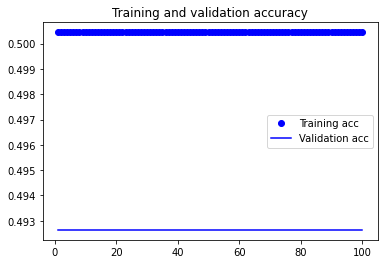

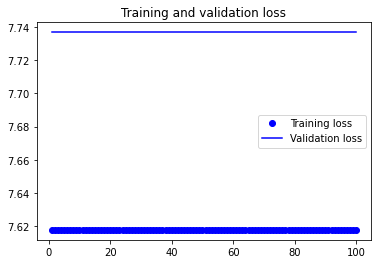

In [22]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()